In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.autograd import Variable

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix

print('setup complete')

setup complete


In [2]:
# Use GPU if available else use CPU

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [3]:
#Taking the dataset directly from torchvision

train_data = torchvision.datasets.FashionMNIST("./data", download=True, transform=
                                                transforms.Compose([transforms.ToTensor()]))

test_data = torchvision.datasets.FashionMNIST("./data", download=True, train=False, transform=
                                               transforms.Compose([transforms.ToTensor()]))  



Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw




Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw




Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw




Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
#create trainloader and testloader
trainloader =  torch.utils.data.DataLoader(train_data, batch_size=4, shuffle=True)
testloader =   torch.utils.data.DataLoader(test_data, batch_size=4, shuffle=False)

trainloader

In [ ]:
# get better understanding

# def imshow(image, ax=None, title=None, normalize=True):
#     """Imshow for Tensor."""
#     if ax is None:
#         fig, ax = plt.subplots()
#     image = image.numpy().transpose((1, 2, 0))

#     if normalize:
#         mean = np.array([0.485, 0.456, 0.406])
#         std = np.array([0.229, 0.224, 0.225])
#         image = std * image + mean
#         image = np.clip(image, 0, 1)

#     ax.imshow(image)
#     ax.spines['top'].set_visible(False)
#     ax.spines['right'].set_visible(False)
#     ax.spines['left'].set_visible(False)
#     ax.spines['bottom'].set_visible(False)
#     ax.tick_params(axis='both', length=0)
#     ax.set_xticklabels('')
#     ax.set_yticklabels('')

#     return ax

# Run this to test your data loaders
# images, labels = next(iter(trainloader))
# print(images, labels)
# imshow(images[1], normalize=False)
# imshow(images[2], normalize=False)


labels of this image is:  9
torch.Size([1, 28, 28])


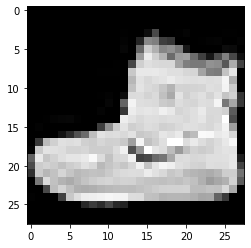

In [5]:
#alternative way to show single image but with less code
image, label = next(iter(train_data))
plt.imshow(image.squeeze(), cmap="gray")
print('labels of this image is: ', label)

image,label=train_data[0]
print(image.shape)

#output shape is 1 which means its a grayscale

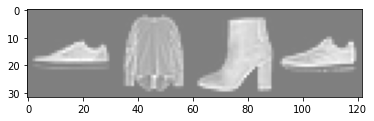

In [6]:
#alternative code to show images but a grid of them
def imshow(img):
    img=img/2+0.5
    npimg=img.numpy()
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.show()
    
dataiter=iter(trainloader)
images,labels=dataiter.next()

imshow(torchvision.utils.make_grid(images))

In [ ]:
# #This is a sequential API approach, creating a class would be 

# model = nn.Sequential(
#     #First COnv2d
#     nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
#     # ((28 - 3(kernel size) + 2 * 1(padding))/ s (stride)) + 1
#     # the dimension of the image after first conv2d is  28*28
#     nn.ReLU(),
    
#     nn.MaxPool2d(2, 2),
#     # after this the dimension of the image would be  14*14

#     #Second Conv2d
#     nn.Conv2d(32, 64, kernel_size=3,stride=1,padding=1),
#     nn.ReLU(),
    
#     nn.Flatten(),
    
#     #First venilla layer
#     nn.Linear(64*14*14, 1024), #we can choose this 1024 neurons
#     nn.ReLU(),
    
#     #second venilla layer
#     nn.Linear(1024, 512),
#     nn.ReLU(),
    
#     nn.Linear(512,10))

In [7]:
# Class with sequential API

class CNN(nn.Module):
    
    def __init__(self):
        super(CNN, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.fc1 = nn.Linear(in_features=64*6*6, out_features=1024)
        #self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(in_features=1024, out_features=512)
        self.fc3 = nn.Linear(in_features=512, out_features=10)
        
        
    def forward(self, x):
        #in forward function, we define how our data flows through these layers
        out = self.conv1(x)
        out = self.conv2(out)
        out = out.reshape(out.size(0), -1)
        #out = nn.Flatten()
        #out = self.drop_out(out)
        out = self.fc1(out)
        out = F.relu(out)
        out = self.fc2(out)
        out = F.relu(out)
        out = self.fc3(out)
        out = F.softmax(out, dim=1)
        return out

model = CNN()
model

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2304, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=10, bias=True)
)

In [8]:
#define the optimizer and the loss
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion = nn.NLLLoss()

print('Initial weights - ', model.fc1.weight)

images, labels = next(iter(trainloader))

# Clear the gradients, do this because gradients are accumulated
optimizer.zero_grad()

# Forward pass, then backward pass, then update weights
output = model.forward(images)
loss = criterion(output, labels)
loss.backward()

print('Gradient -', model.fc1.weight.grad)
optimizer.step()

Initial weights -  Parameter containing:
tensor([[-2.0286e-02, -3.4112e-03,  9.4547e-03,  ..., -2.1086e-03,
         -6.2596e-03, -1.2849e-02],
        [ 3.1238e-03,  8.9586e-03,  1.9366e-02,  ...,  1.7983e-02,
          9.0477e-03, -4.3752e-03],
        [ 1.0893e-02, -6.5374e-03, -7.8782e-03,  ..., -3.8608e-03,
          3.4581e-03, -6.9343e-05],
        ...,
        [-5.7497e-03,  1.3641e-03, -6.1766e-03,  ..., -6.5469e-03,
          1.2711e-04,  1.9286e-02],
        [ 3.9495e-03,  1.6405e-02, -1.4044e-02,  ..., -1.8320e-03,
          7.5930e-03, -2.4339e-03],
        [-6.7451e-03,  2.1718e-03, -1.0526e-02,  ..., -2.0374e-02,
         -7.3887e-04, -5.1562e-03]], requires_grad=True)
Gradient - tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 8.8360e-06,  4.1802e-05,  1.7079e-06,  ...,  8.8955e-05,
          3.6734e-05,  3.9583e-05],
        [ 1.7087e-05,  1.5308e-05,  2.3970e-05,  ...,  6.3569e-05,
          5.6980e-05,  

In [14]:
epochs = 3
print_every = 40

train_loss = []
val_loss = []

for e in range(epochs):
    running_loss = 0
    print(f"Epoch: {e+1}/{epochs}")

    for i, (images, labels) in enumerate(iter(trainloader)):

        # Flatten MNIST images into a 784 long vector
        #images.resize_(images.size()[0], 784)
        
        optimizer.zero_grad()
        
        output = model.forward(images)   # 1) Forward pass
        loss = criterion(output, labels) # 2) Compute loss
        loss.backward()                  # 3) Backward pass
        optimizer.step()                 # 4) Update model
        
        running_loss += loss.item()
        
        if i % print_every == 0:
            print(f"\tIteration: {i}\t Loss: {running_loss/print_every:.4f}")
            running_loss = 0 

    train_loss.append(running_loss/trainloader.shape[0])

    correct = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for i, (images, labels) in enumerate(iter(testloader)):
            #images, labels = data
            # calculate outputs by running images through the network
            #images = images.resize_(images.size()[0],  784)
            outputs = model(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 10000 test images: %d %%' % (
        100 * correct / total))

Epoch: 1/3
	Iteration: 0	 Loss: -0.0187
	Iteration: 40	 Loss: -0.7243
	Iteration: 80	 Loss: -0.7677
	Iteration: 120	 Loss: -0.7887
	Iteration: 160	 Loss: -0.7106
	Iteration: 200	 Loss: -0.7418
	Iteration: 240	 Loss: -0.7186
	Iteration: 280	 Loss: -0.7616
	Iteration: 320	 Loss: -0.6748
	Iteration: 360	 Loss: -0.7592
	Iteration: 400	 Loss: -0.6936
	Iteration: 440	 Loss: -0.7754
	Iteration: 480	 Loss: -0.7322
	Iteration: 520	 Loss: -0.7297
	Iteration: 560	 Loss: -0.7226
	Iteration: 600	 Loss: -0.7659
	Iteration: 640	 Loss: -0.7462
	Iteration: 680	 Loss: -0.8185
	Iteration: 720	 Loss: -0.7252
	Iteration: 760	 Loss: -0.7464
	Iteration: 800	 Loss: -0.7538
	Iteration: 840	 Loss: -0.7349
	Iteration: 880	 Loss: -0.7524
	Iteration: 920	 Loss: -0.7246
	Iteration: 960	 Loss: -0.7335
	Iteration: 1000	 Loss: -0.8259
	Iteration: 1040	 Loss: -0.7791
	Iteration: 1080	 Loss: -0.7589
	Iteration: 1120	 Loss: -0.7596
	Iteration: 1160	 Loss: -0.6963
	Iteration: 1200	 Loss: -0.8134
	Iteration: 1240	 Loss: -0

In [27]:
#import os

#cwd = os.getcwd()

PATH = 'Model_75%.pt'
torch.save(model.state_dict(), PATH)
